In [97]:
import numpy as np
import xarray as xr
from datetime import datetime
import cftime
import matplotlib.pyplot as plt
from climatetranslation.unit.data import (
    get_dataset, 
    dataset_time_overlap, 
    any_calendar_to_datetime,
    construct_regridders,
    even_lat_lon,
)

from climatetranslation.unit.translate import (
    network_translate_constructor,
    get_data_transformer
)
from climatetranslation.unit.utils import get_config

from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs

In [106]:
conf = get_config("/home/dfulu/model_outputs/outputs/hadgem3_to_cam5_nat-hist-v5/config.yaml")

In [107]:
conf

{'image_save_iter': 1000,
 'image_display_iter': 100,
 'display_size': 16,
 'snapshot_save_iter': 1000,
 'log_iter': 10,
 'max_iter': 1000000,
 'batch_size': 6,
 'weight_decay': 0.0001,
 'beta1': 0.5,
 'beta2': 0.999,
 'init': 'kaiming',
 'lr': 0.0001,
 'lr_policy': 'step',
 'step_size': 100000,
 'gamma': 0.5,
 'gan_w': 4,
 'recon_x_w': 10,
 'recon_h_w': 0,
 'recon_kl_w': 0.01,
 'recon_x_cyc_w': 10,
 'recon_kl_cyc_w': 0.01,
 'vgg_w': 0,
 'gen': {'dim': 64,
  'mlp_dim': 256,
  'style_dim': 8,
  'activ': 'relu',
  'n_downsample': 2,
  'n_res': 4,
  'pad_type': 'zero',
  'upsample': 'nearest',
  'output_activ': ['relu', 'none', 'none', 'none']},
 'dis': {'dim': 64,
  'norm': 'none',
  'activ': 'lrelu',
  'n_layer': 4,
  'gan_type': 'lsgan',
  'num_scales': 3,
  'pad_type': 'reflect'},
 'num_workers': 5,
 'data_zarr_a': '/datadrive/hadgem3/nat_hist_zarr',
 'data_zarr_b': '/datadrive/cam5/nat_hist_zarr',
 'agg_data_a': '/datadrive/hadgem3/nat_hist_agg.nc',
 'agg_data_b': '/datadrive/cam5/na

In [118]:
conf['split_at'] = 360

conf['bbox'] = {
  'N': 90,
  'S': -90,
  'E': 360,
  'W': 0
}

conf['time_range'] = 'overlap'
conf['resolution_match'] = 'downscale'
conf['scale_method'] = 'bilinear'

In [126]:
ds_a

,Array,Chunk
Bytes,108.84 GB,559.87 kB
Shape,"(10, 19440, 324, 432)","(1, 1, 324, 432)"
Count,388801 Tasks,194400 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,108.84 GB,559.87 kB
Shape,"(10, 19440, 324, 432)","(1, 1, 324, 432)"
Count,388801 Tasks,194400 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [127]:
xr.open_dataset("/datadrive/hadgem3/nat_hist_agg.nc")

<xarray.Dataset>
Dimensions:              (aggregate_statistic: 8, height: 2, lat: 324, lon: 432)
Coordinates:
  * lon                  (lon) float32 0.41666666 1.25 ... 358.75 359.5833
  * lat                  (lat) float32 -89.72222 -89.166664 ... 89.72223
  * height               (height) float32 0.0 2.0
  * aggregate_statistic  (aggregate_statistic) object 'mean' 'std' ... 'max_log'
Data variables:
    pr                   (aggregate_statistic, height, lat, lon) float32 ...
    tas                  (aggregate_statistic, height, lat, lon) float32 ...
    tasmax               (aggregate_statistic, height, lat, lon) float32 ...
    tasmin               (aggregate_statistic, height, lat, lon) float32 ...
    pr_4root             (aggregate_statistic, height, lat, lon) float32 ...
Attributes:
    log_calculation_note:  Calculated from log(x-x.min()+1)

In [114]:
# load the datasets
ds_a = get_dataset(conf['data_zarr_a'], conf['level_vars'], 
                   filter_bounds=False, split_at=conf['split_at'], 
                   bbox=conf['bbox'])
ds_b = get_dataset(conf['data_zarr_b'], conf['level_vars'], 
                   filter_bounds=False, split_at=conf['split_at'], 
                   bbox=conf['bbox'])
    
if conf['time_range'] is not None:
    if conf['time_range'] == 'overlap':
        ds_a, ds_b = dataset_time_overlap([ds_a, ds_b])
    elif isinstance(conf['time_range'], dict):
        time_slice = slice(conf['time_range']['start_date'], conf['time_range']['end_date'])
        ds_a = ds_a.sel(time=time_slice)
        ds_b = ds_b.sel(time=time_slice)
    else:
        raise ValueError("time_range not valid : {}".format(conf['time_range']))

{'N': 90, 'S': -90, 'E': 360, 'W': 0}
{'N': 90, 'S': -90, 'E': 360, 'W': 0}
start time (1960-01-01T12:00:00) and end time (2013-12-30T12:00:00)


In [119]:
prepost_trans = get_data_transformer(conf)
prepost_trans.fit(ds_a, ds_b)

Create weight file: bilinear_324x432_192x288.nc
Remove file bilinear_324x432_192x288.nc


/anaconda/envs/py37_pytorch2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [121]:
class Empty:
    pass

args = Empty()
args.x2x = 'b2a'
args.checkpoint = ("/home/dfulu/model_outputs/outputs/"
                   +"hadgem3_to_cam5_nat-hist-v5/checkpoints/gen_00056000.pt")

ds_a = even_lat_lon(prepost_trans.transform_a(ds_a))
ds_b = even_lat_lon(prepost_trans.transform_b(ds_b))
post_trans = prepost_trans.inverse_a if args.x2x[-1]=='a' else prepost_trans.inverse_b
    
# load model 
conf['input_dim_a'] = len(ds_a.keys())
conf['input_dim_b'] = len(ds_b.keys())
conf['land_mask_a'] = get_land_mask(ds_a)
conf['land_mask_b'] = get_land_mask(ds_b)
net_trans = network_translate_constructor(conf, args.checkpoint, args.x2x)

ds = ds_a if args.x2x[0]=='a' else ds_b

using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


ValueError: dimensions cannot change for in-place operations

In [ ]:

    
    
    
    with progressbar.ProgressBar(max_value=N_times) as bar:
        
        for i in range(0, N_times, n_times):
            
            # pre-rocess and convert to array
            da = (
                ds.isel(time=slice(i, min(i+n_times, N_times)))
                .to_array()
                .transpose('run', 'time', 'variable', 'lat', 'lon')
            )
            
            # transform through network 
            da = xr.apply_ufunc(
                net_trans, 
                da,
                vectorize=True,
                dask='allowed',
                output_dtypes=['float'],
                input_core_dims=[['variable', 'lat', 'lon']],
                output_core_dims=[['variable', 'lat', 'lon']]
            )
            
            # fix chunking
            da = da.chunk(dict(run=1, time=1, lat=-1, lon=-1))
            
            # post-process
            ds_translated = post_trans(da.to_dataset(dim='variable'))
            
            # append to zarr
            ds_translated.to_zarr(
                args.output_zarr, 
                mode=mode, 
                append_dim=append_dim,
                consolidated=True
            )
            
            # update progress bar and change modes so dat can be appended
            bar.update(i)
            mode, append_dim='a', 'time'
            
        bar.update(N_times)

In [79]:
conf_levels = {
    0: ['pr'], 
    2:['tas', 'tasmin', 'tasmax'], 
}

bbox = {
  'N': 30,
  'S': -2,
  'E': 100,
  'W': 55
}

In [80]:
def select_months(da, months, drop=False):
    in_months = xr.DataArray(np.isin(da['time.month'], months), coords=[da.time])
    return da.where(in_months, drop=drop)

def common_min_max(das):
    vmin = min([da.min() for da in das])
    vmax = max([da.max() for da in das])
    return vmin, vmax

In [82]:
model = 'hadgem3'
other_model = ({'cam5','hadgem3'} - {model}).pop()

ds_target = get_dataset(f"/datadrive/{model}/nat_hist_zarr", 
                      conf_levels, 
                      filter_bounds=False,
                      split_at=360, 
                      bbox=bbox)
ds_base = get_dataset(f"/datadrive/{other_model}/nat_hist_zarr", 
                      conf_levels, 
                      filter_bounds=False,
                      split_at=360, 
                      bbox=bbox)
ds_trans = get_dataset(f"/datadrive/{other_model}/nat_hist_to_{model[:3]}_v5.1_zarr", 
                       conf_levels, 
                       filter_bounds=False, 
                       split_at=360, 
                       bbox=bbox)
ds_qm = get_dataset(f"/datadrive/{other_model}/nat_hist_qm_to_{model[:3]}_zarr", 
                       conf_levels, 
                       filter_bounds=False, 
                       split_at=360, 
                       bbox=bbox)

rg_t, rg_b = construct_regridders(
    ds_target, 
    ds_base, 
    resolution_match='downscale', 
    scale_method='conservative', 
    periodic=False)

if rg_t is not None:
    ds_target = rg_t(ds_target)
if rg_b is not None:
    ds_base = rg_b(ds_base)

{'N': 30, 'S': -2, 'E': 100, 'W': 55}
{'N': 30, 'S': -2, 'E': 100, 'W': 55}
{'N': 30, 'S': -2, 'E': 100, 'W': 55}
{'N': 30, 'S': -2, 'E': 100, 'W': 55}
Create weight file: conservative_58x54_34x37.nc
Remove file conservative_58x54_34x37.nc
using dimensions ('lat', 'lon') from data variable pr as the horizontal dimensions for this dataset.


In [92]:
samples = [select_months(ds.pr.isel(run=0), [6, 7, 8, 9], drop=True).sel(time="1961-07-01") for ds in [ds_target, ds_base, ds_trans, ds_qm]]
[s.time.values for s in samples]

[array([cftime.Datetime360Day(1961, 7, 1, 12, 0, 0, 0)], dtype=object),
 array([cftime.DatetimeNoLeap(1961, 7, 1, 12, 0, 0, 0)], dtype=object),
 array([cftime.DatetimeNoLeap(1961, 7, 1, 12, 0, 0, 0)], dtype=object),
 array([cftime.DatetimeNoLeap(1961, 7, 1, 12, 0, 0, 0)], dtype=object)]

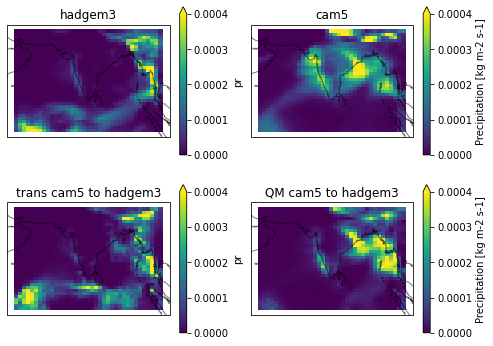

In [93]:
vmin, vmax = 0, 0.0004
plt.figure(figsize=(8,6))
axes = [plt.subplot(221+i, projection=ccrs.PlateCarree()) for i in range(4)]
titles = [model, other_model, f"trans {other_model} to {model}", f"QM {other_model} to {model}"]
for da, ax, title in zip(samples, axes, titles):
    da.plot(ax=ax, vmin=vmin, vmax=vmax)
    ax.coastlines(alpha=0.5)
    ax.set_title(title)
plt.show()

In [87]:
results = []
with ProgressBar(dt=10):
    for ds in [ds_target, ds_base, ds_trans, ds_qm]:
        results.append(select_months(ds.pr.isel(run=0), [6, 7, 8, 9], drop=True).mean(dim='time').compute())

[########################################] | 100% Completed | 30.0s
[########################################] | 100% Completed | 20.0s
[########################################] | 100% Completed | 20.0s
[########################################] | 100% Completed | 10.0s


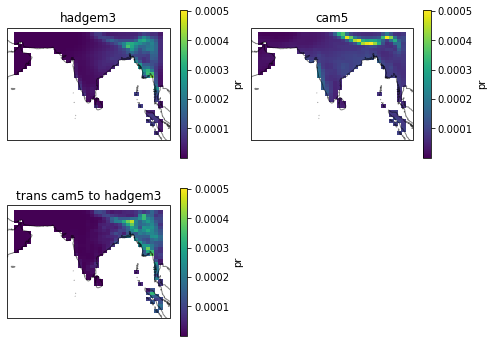

In [96]:
land_mask = True

vmin, vmax = common_min_max(results[:3])
#vmin, vmax = 0, 0.00015

plt.figure(figsize=(8,6))
axes = [plt.subplot(221+i, projection=ccrs.PlateCarree()) for i in range(3)]
titles = [model, other_model, f"trans {other_model} to {model}", f"QM {other_model} to {model}"]
for da, ax, title in zip(results, axes, titles):
    if land_mask:
        da.where(get_land_mask(da)[0]).plot(ax=ax, vmin=vmin, vmax=vmax)
    else:
        da.plot(ax=ax, vmin=vmin, vmax=vmax)
    ax.coastlines(alpha=0.5)
    ax.set_title(title)
plt.show()

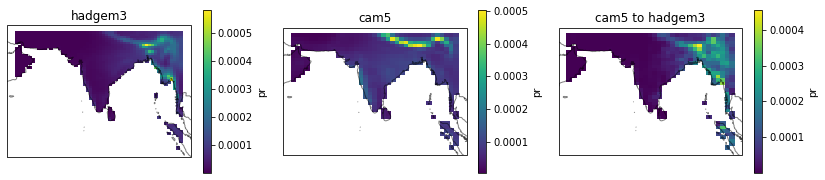

In [52]:
land_mask = True

plt.figure(figsize=(14,3))
axes = [plt.subplot(131+i, projection=ccrs.PlateCarree()) for i in range(3)]
titles = [model, other_model, f"{other_model} to {model}"]
for da, ax, title in zip(results, axes, titles):
    if land_mask:
        da.where(get_land_mask(da)[0]).plot(ax=ax)
    else:
        da.plot(ax=ax)
    ax.coastlines(alpha=0.5)
    ax.set_title(title)
plt.show()

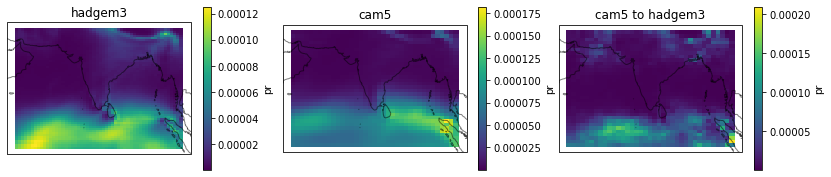

In [43]:
# this was Jan only
plt.figure(figsize=(14,3))
axes = [plt.subplot(131+i, projection=ccrs.PlateCarree()) for i in range(3)]
titles = [model, other_model, f"{other_model} to {model}"]
for da, ax, title in zip(results, axes, titles):
    da.plot(ax=ax)
    ax.coastlines(alpha=0.5)
    ax.set_title(title)
plt.show()

In [58]:
import cartopy.crs as ccrs
from skimage.metrics import structural_similarity as ssim



def calc_range(das):
    vmin, vmax = common_min_max(das)
    return (vmax - vmin).values

def add_ssim_mae(x1, x2, ax, data_range=None):
    s = ssim(x1, x2, data_range=data_range)
    mae = np.abs(x1 - x2).mean()
    ax.text(0.5, -0.1, 
            f'SSIM: {s:.3f} | MAE: {mae:.3f}', 
            ha='center', 
            va='center', 
            transform=ax.transAxes)

def plot_row(events_das, axes, form):
    vmin, vmax = common_min_max(events_das)
    if form=='relative':
        vmax = max([-vmin, vmax])
        vmin = -vmax
    data_range = calc_range(events_das)
    for e_da, ax in zip(events_das, axes):
        e_da.plot(ax=ax, vmin=vmin, vmax=vmax, cmap='RdBu_r')
        add_ssim_mae(e_da.values, events_das[0].values, ax, data_range=data_range)

def compare_events(event_target, event_trans, event_base, target_model=None, form='relative'):
    plt.figure(figsize=(12, 8))
    axes = [plt.subplot(331+i, projection=ccrs.PlateCarree()) for i in range(9)]
    events = [e.sel(form=form) for e in [event_target, event_trans, event_base]]
    
    plot_row([e.tas for e in events], axes[0:3], form)
    plot_row([e.z500 for e in events], axes[3:6], form)
    plot_row([e.pr for e in events], axes[6:9], form) 
    
    if target_model is None:
        titles = ['target', 'translation', 'base']
    else:
        other_model = ({'era5','hadgem3'} - {target_model}).pop()
        titles = [target_model, f"{other_model} to {target_model}", other_model]
    for ax, title in zip(axes[:3], titles):
        ax.set_title(title)
    for ax in axes[3:]:
        ax.set_title('')
    for ax in axes: ax.coastlines(alpha=0.5)